# PKIS1 dataset curation

## Backgroud:
 Kinases play a crucial role in cellular signalling, making them important targets for drug development. Dysregulation of kinases is frequently implicated in diseases like cancer, inflammation, and neurodegenerative disorders. Therefore, targeting kinases with specific drugs has emerged as a crucial strategy in modern drug discovery. Kinase-related task includes inhibition prediction, selectivity prediction, or kinase-ligand binding affinity prediction. In the early release version of Polaris, benchmarks were established for kinases such as EGFR, KIT, and RET, along with their respective mutations, as well as for LOK and SLK.

An example of Kinase screening (image from [here](https://www.medchemexpress.com/Kinase-screening.html)):
![kinase](https://file.medchemexpress.com/new/images/web/kinase-tree-en.png)

## Description of readout 
- **Readouts**:
 - `EGFR`,`EGFR_(L858R_mutant)`
 - `KIT`, `KIT_(T6701_mutant)`, `KIT_(V560G_mutant)`
 - `RET`, `RET_(V804L_mutant)`, `RET_(Y791F_mutant)`
- **Bioassay readout**: Percentage of inhibition (%).
- **Optimization objective**: Higher potency (higher %inhibition).


## Data resource:
PKIS 1: A set of 364 unique small-molecule ATP-competitive kinase inhibitors that was screened by the set in activity assays with 224 recombinant kinases and 24 G protein-coupled receptors and in cellular assays of cancer cell proliferation and angiogenesis.

**Reference**: https://pubmed.ncbi.nlm.nih.gov/26501955

<!-- ## Related benchmarks -->
<!-- TODO: to be added -->

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import pandas as pd
import datamol as dm

root = pathlib.Path("__file__").absolute().parents[2]
# set to recipe root directory
os.chdir(root)
sys.path.insert(0, str(root))

In [2]:
org = "polaris"
data_name = "drewry2014_pkis1_subset"
dirname = dm.fs.join(root, f"org-{org}", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/{data_name}"

/Users/lu.zhu/miniconda3/envs/po_dataset/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the raw data
The dataset is published in https://pubmed.ncbi.nlm.nih.gov/26501955

In [3]:
# Load the data
source_data_path = f"{gcp_root}/data/raw/pkis_matrix_1uM.parquet"
data = pd.read_parquet(source_data_path)

### Define data columns and structure column. Remove empty rows.

In [4]:
import re


def clean_string(input_string):
    # Define the pattern to match spaces and brackets
    pattern = r"[\(\)\(\){}]"

    # Use re.sub() to replace the matched patterns with an empty string
    input_string = re.sub(" mutant", "", input_string)
    input_string = re.sub(" ", "_", input_string)
    cleaned_string = re.sub(pattern, "", input_string)

    return cleaned_string


data = data.rename(columns={col: clean_string(col) for col in data.columns})
mol_col = "Smiles"
data_cols = [
    "EGFR_L858R",
    "EGFR",
    "KIT_T6701",
    "KIT_V560G",
    "KIT",
    "RET_V804L",
    "RET_Y791F",
    "RET",
]
data = data[[mol_col] + data_cols]
data = data.dropna(subset=data_cols, how="all", axis=0)

In [5]:
data.columns

Index(['Smiles', 'EGFR_L858R', 'EGFR', 'KIT_T6701', 'KIT_V560G', 'KIT',
       'RET_V804L', 'RET_Y791F', 'RET'],
      dtype='object')

In [6]:
data.describe(include="all")

,Smiles,EGFR_L858R,EGFR,KIT_T6701,KIT_V560G,KIT,RET_V804L,RET_Y791F,RET
count,366,366.000000,365.000000,366.000000,366.000000,365.000000,366.000000,365.000000,365.000000
unique,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,C#Cc1cccc(Nc2ncnc3ccc(OCCCCNCCS(C)(=O)=O)cc23)c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,19.306325,16.719288,13.226175,12.752158,26.747178,18.211011,24.460123,21.998904
std,NaN,27.276753,26.484272,24.209365,23.535177,33.886105,22.263974,24.631992,25.271774
min,NaN,-5.940000,-20.030000,-3.320000,-3.930000,-26.190000,-3.850000,-4.940000,-1.840000
25%,NaN,2.642500,2.620000,1.247500,0.340000,3.600000,4.402500,7.110000,5.380000
50%,NaN,6.425000,5.530000,3.630000,2.950000,8.760000,8.985000,13.890000,9.600000
75%,NaN,22.092500,11.920000,7.360000,10.367500,45.850000,20.637500,33.580000,28.980000


### Define threshold for classification conversion
> The authors in the reference paper used a stringent threshold `%inhibition > 90` to identify the hit. Here, we loss the thresholds according to the distributions. 

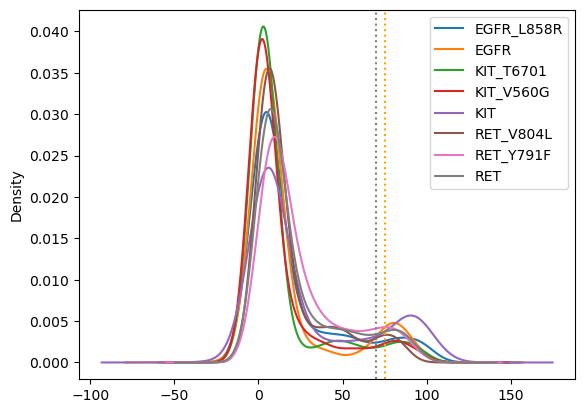

In [7]:
from matplotlib import pyplot as plt

data[data_cols].plot.kde()
plt.axvline(x=75, linestyle="dotted", color="orange")
plt.axvline(x=70, linestyle="dotted", color="grey")

### Perform data curation with `auroris.curation` module
The curation process includes:
- assign unique identifier to molecules
- detect the stereochemistry information of molecules.
- inspect the potential outliers of bioactivity values
- merge rows of replicated molecules
- detect isomers which show the activity shifts

Check out the curation module in [Auroris](https://github.com/polaris-hub/auroris). 

In [8]:
data_cols = [
    "EGFR_L858R",
    "EGFR",
    "KIT_T6701",
    "KIT_V560G",
    "KIT",
    "RET_V804L",
    "RET_Y791F",
    "RET",
]

In [9]:
# import key curation components from auroris
from auroris.curation import Curator
from auroris.curation.actions import (
    MoleculeCuration,
    OutlierDetection,
    Deduplication,
    StereoIsomerACDetection,
    ContinuousDistributionVisualization,
    Discretization,
)

# Define the curation workflow
curator = Curator(
    data_path=source_data_path,
    steps=[
        MoleculeCuration(input_column=mol_col, y_cols=data_cols),
        Discretization(input_column="EGFR", thresholds=[75], label_order="ascending"),
        Discretization(
            input_column="EGFR_L858R", thresholds=[75], label_order="ascending"
        ),
        Discretization(input_column="KIT", thresholds=[75], label_order="ascending"),
        Discretization(
            input_column="KIT_T6701", thresholds=[75], label_order="ascending"
        ),
        Discretization(
            input_column="KIT_V560G", thresholds=[75], label_order="ascending"
        ),
        Discretization(input_column="RET", thresholds=[70], label_order="ascending"),
        Discretization(
            input_column="RET_V804L", thresholds=[70], label_order="ascending"
        ),
        Discretization(
            input_column="RET_Y791F", thresholds=[70], label_order="ascending"
        ),
        OutlierDetection(
            method="zscore", columns=data_cols, threshold=3, use_modified_zscore=True
        ),
        StereoIsomerACDetection(y_cols=[f"CLS_{col}" for col in data_cols]),
    ],
    parallelized_kwargs={"n_jobs": -1},
)

curator.to_json(f"{dirname}/inspection_config.json")

In [10]:
# Run the curation step defined as above
data_inspection, report = curator(data)

2024-07-30 12:06:13.671 | INFO     | auroris.curation._curator:transform:106 - Performing step: mol_curation
2024-07-30 12:06:29.919 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:06:29.975 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:06:30.026 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:06:30.077 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:06:30.131 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:06:30.184 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:06:30.237 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:06:30.288 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:06:30.340 | INFO     

In [11]:
#  get the curation logger
from auroris.report.broadcaster import LoggerBroadcaster

broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-07-30 12:06:13
Version: 0.1.4.dev10+g6715566
===== mol_curation =====
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to visualize the chemical space.
[LOG]: Molecules with undefined stereocenter detected: 9.
[IMG]: Dimensions 2400 x 2400
[IMG]: Dimensions 1200 x 900
===== discretize =====
[LOG]: New column added: CLS_EGFR
[IMG]: Dimensions 1200 x 600
===== discretize =====
[LOG]: New column added: CLS_EGFR_L858R
[IMG]: Dimensions 1200 x 600
===== discretize =====
[LOG]: New column added

In [12]:
# Generate an HTML report with embedded visualizations showcasing the data analysis.
from utils.auroris_utils import HTMLBroadcaster

# export report to local directory
broadcaster = HTMLBroadcaster(report, f"{dirname}/inspection_report")
report_path = broadcaster.broadcast()

In [13]:
# check the curated data
data_inspection.describe(include="all")

,Smiles,EGFR_L858R,EGFR,KIT_T6701,KIT_V560G,KIT,RET_V804L,RET_Y791F,RET,MOL_smiles,...,OUTLIER_RET_Y791F,OUTLIER_RET,AC_CLS_EGFR_L858R,AC_CLS_EGFR,AC_CLS_KIT_T6701,AC_CLS_KIT_V560G,AC_CLS_KIT,AC_CLS_RET_V804L,AC_CLS_RET_Y791F,AC_CLS_RET
count,366,366.000000,365.000000,366.000000,366.000000,365.000000,366.000000,365.000000,365.000000,366,...,366,366,366,366,366,366,366,366,366,366
unique,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,364,...,1,1,1,1,1,1,1,1,2,2
top,C#Cc1cccc(Nc2ncnc3ccc(OCCCCNCCS(C)(=O)=O)cc23)c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nc1ncnc2occ(-c3ccc(NC(=O)Nc4cc(C(F)(F)F)ccc4F)...,...,False,False,False,False,False,False,False,False,False,False
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,366,366,366,366,366,366,366,366,362,364
mean,NaN,19.306325,16.719288,13.226175,12.752158,26.747178,18.211011,24.460123,21.998904,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,27.276753,26.484272,24.209365,23.535177,33.886105,22.263974,24.631992,25.271774,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,-5.940000,-20.030000,-3.320000,-3.930000,-26.190000,-3.850000,-4.940000,-1.840000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2.642500,2.620000,1.247500,0.340000,3.600000,4.402500,7.110000,5.380000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,6.425000,5.530000,3.630000,2.950000,8.760000,8.985000,13.890000,9.600000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,22.092500,11.920000,7.360000,10.367500,45.850000,20.637500,33.580000,28.980000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check the activity shift between the stereo isomers


![ac_stereo_CLS_RET_Y791F](inspection_report/images/18-Activity_shifts_among_stereoisomers__CLS_RET_Y791F.png)


![ac_stereo_CLS_RET](inspection_report/images/19-Activity_shifts_among_stereoisomers__CLS_RET.png)


In [14]:
# Check the stereoisomers
data.loc[[136, 137, 302, 309], [col for col in data.columns if "RET" in col]]

,RET_V804L,RET_Y791F,RET
136,38.26,72.03,72.10
137,54.75,63.76,51.82
302,73.94,68.99,71.26
309,78.31,72.37,79.90


With the predefined threshold value `>70`, a few of molecules has been detected having activity shift between the isomer for `RET_(Y791F_mutant)`, and `RET`. 
For the stereoisomers #136 and #137, the activity value on target `RET_(Y791F_mutant)` are very close, while there is a significant difference for target `RET`. The stereocenters of the pair of stereoisomers are well annotated.


For the second pair (#302 and #309) - the double bond isomers, the stereo information is not specified for the first molecule(#309). Given the activity values are similar. Therefore, we consider keeping the molecule #302 for the target `RET_(Y791F_mutant)`.

In [15]:
# mask clf value for #309
data.loc[309, "RET_Y791F"] = None
# Mask clf value for #136, #137
data.loc[[136, 137], ["RET", "RET_Y791F"]] = None

## Rerun data curation and export curated data for downstream tasks


### Rerun the curation steps

In [16]:
curator = Curator(
    data_path=source_data_path,
    steps=[
        MoleculeCuration(input_column=mol_col, y_cols=data_cols),
        Deduplication(
            deduplicate_on=mol_col, y_cols=data_cols
        ),  # remove the replicated molecules
        Discretization(input_column="EGFR", thresholds=[75], label_order="ascending"),
        Discretization(
            input_column="EGFR_L858R", thresholds=[75], label_order="ascending"
        ),
        Discretization(input_column="KIT", thresholds=[75], label_order="ascending"),
        Discretization(
            input_column="KIT_T6701", thresholds=[75], label_order="ascending"
        ),
        Discretization(
            input_column="KIT_V560G", thresholds=[75], label_order="ascending"
        ),
        Discretization(input_column="RET", thresholds=[70], label_order="ascending"),
        Discretization(
            input_column="RET_V804L", thresholds=[70], label_order="ascending"
        ),
        Discretization(
            input_column="RET_Y791F", thresholds=[70], label_order="ascending"
        ),
        OutlierDetection(
            method="zscore", columns=data_cols, threshold=3, use_modified_zscore=True
        ),
        StereoIsomerACDetection(y_cols=[f"CLS_{col}" for col in data_cols]),
    ],
    parallelized_kwargs={"n_jobs": -1},
)

# The final curation configuration is exported for reproducibility
path = f"{gcp_root}/data/curation/curation_config.json"
curator.to_json(path)

In [18]:
# Run the curation step defined as above
data_curated, report = curator(data)

2024-07-30 12:07:59.686 | INFO     | auroris.curation._curator:transform:106 - Performing step: mol_curation
2024-07-30 12:08:01.541 | INFO     | auroris.curation._curator:transform:106 - Performing step: deduplicate
2024-07-30 12:08:01.879 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:08:01.933 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:08:01.985 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:08:02.035 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:08:02.090 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:08:02.144 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:08:02.196 | INFO     | auroris.curation._curator:transform:106 - Performing step: discretize
2024-07-30 12:08:02.246 | INFO    

In [19]:
# Export report to polaris public directory on GCP
# The report is ready to reviewed in the HTML file.
broadcaster = HTMLBroadcaster(
    report, f"{gcp_root}/data/curation/report", embed_images=True
)
broadcaster.broadcast()

'gs://polaris-public/polaris-recipes/org-polaris/drewry2014_pkis1_subset/data/curation/report/index.html'

In [20]:
broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-07-30 12:07:59
Version: 0.1.4.dev10+g6715566
===== mol_curation =====
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to visualize the chemical space.
[LOG]: Molecules with undefined stereocenter detected: 9.
[IMG]: Dimensions 2400 x 2400
[IMG]: Dimensions 1200 x 900
===== deduplicate =====
[LOG]: Deduplication merged and removed 0 duplicated molecules from dataset
===== discretize =====
[LOG]: New column added: CLS_EGFR
[IMG]: Dimensions 1200 x 600
===== discretize =====
[LOG]: New colu

## Export the final curated data

In [21]:
fout = f"{gcp_root}/data/curation/{data_name}_curated.csv"
data_curated.reset_index(drop=True).to_csv(fout, index=False)

In [22]:
fout

'gs://polaris-public/polaris-recipes/org-polaris/drewry2014_pkis1_subset/data/curation/drewry2014_pkis1_subset_curated.csv'